# Library & Dataset

In [1]:
import os

folder_path = "R:/Data Science/ZDS/Intership/Banao/Dataset"

# Check if the folder exists
if os.path.exists(folder_path):
    # List all files and directories in the folder
    folder_contents = os.listdir(folder_path)
    
    # Print the contents
    print("Contents of the 'images' folder:")
    for item in folder_contents:
        print(item)
else:
    print("The 'images' folder does not exist.")


Contents of the 'images' folder:
buttons
checkbox
Container
dropdown Forms
input fields
links
logo images
modal
Navigation dots
radio
text


In [2]:
os.listdir(folder_path)

['buttons',
 'checkbox',
 'Container',
 'dropdown Forms',
 'input fields',
 'links',
 'logo images',
 'modal',
 'Navigation dots',
 'radio',
 'text']

In [3]:
for cls in os.listdir(folder_path):
    print(cls, ':', len(os.listdir(folder_path + '/' + cls)))

buttons : 4
checkbox : 4
Container : 4
dropdown Forms : 4
input fields : 4
links : 4
logo images : 4
modal : 4
Navigation dots : 4
radio : 4
text : 4


# Import the Dataset Into PyTorch

In [4]:
from torchvision.datasets import ImageFolder

In [5]:
dataset = ImageFolder(folder_path)

In [6]:
len(dataset)

42

In [7]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=2400x1800>, 0)

In [8]:
dataset.classes

['Container',
 'Navigation dots',
 'buttons',
 'checkbox',
 'dropdown Forms',
 'input fields',
 'links',
 'logo images',
 'modal',
 'radio',
 'text']

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

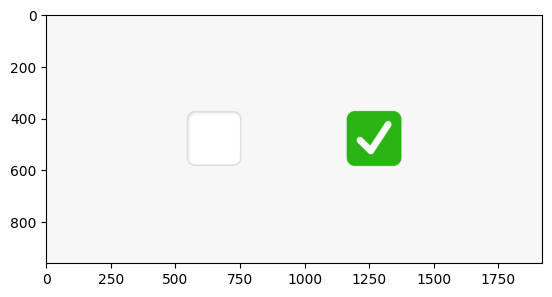

In [10]:
img, label = dataset[12]
plt.imshow(img)

In [11]:
import torchvision.transforms as tt

dataset = ImageFolder(folder_path, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

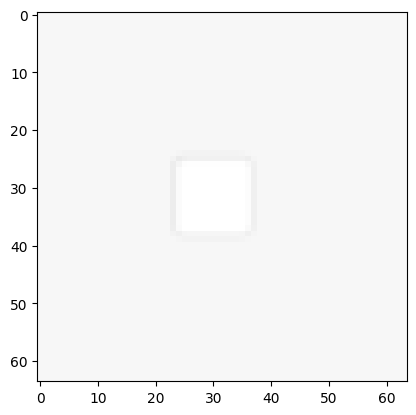

In [12]:
img, label = dataset[12]
plt.imshow(img.permute((1, 2, 0)))

In [13]:
val_pct = 0.3
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(30, 12)

In [14]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(30, 12)

In [15]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

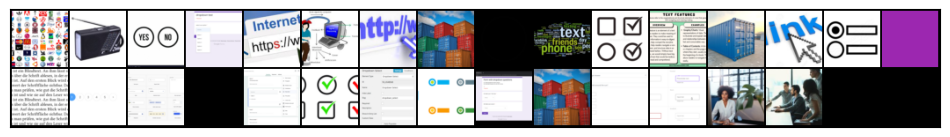

In [17]:
show_batch(train_dl)

# GPU & CPU Utilities

In [18]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
torch.cuda.is_available()

False

In [20]:
device = get_default_device()

In [21]:
device

device(type='cpu')

In [22]:
img, label = dataset[0]

In [23]:
img.device

device(type='cpu')

In [24]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model and Training Utilties

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [29]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [30]:
model.conv1[0].weight.device

device(type='cpu')

# Training

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.4002106189727783, 'val_acc': 0.0833333358168602}]

In [32]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 4.5812, val_loss: 2.3962, val_acc: 0.1667
Epoch [1], train_loss: 2.1882, val_loss: 2.4989, val_acc: 0.0000
Epoch [2], train_loss: 2.6956, val_loss: 2.6674, val_acc: 0.0000
Epoch [3], train_loss: 1.9210, val_loss: 2.8603, val_acc: 0.0000
Epoch [4], train_loss: 1.0356, val_loss: 3.0591, val_acc: 0.0000


In [33]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.6247, val_loss: 3.5674, val_acc: 0.0000
Epoch [1], train_loss: 2.5888, val_loss: 3.9127, val_acc: 0.0000
Epoch [2], train_loss: 1.5042, val_loss: 5.0737, val_acc: 0.0000
Epoch [3], train_loss: 0.8932, val_loss: 8.1668, val_acc: 0.0000
Epoch [4], train_loss: 0.5979, val_loss: 9.8652, val_acc: 0.0000


In [34]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.2589, val_loss: 9.1805, val_acc: 0.0000
Epoch [1], train_loss: 0.2115, val_loss: 8.3369, val_acc: 0.0000
Epoch [2], train_loss: 0.1885, val_loss: 7.7264, val_acc: 0.0000
Epoch [3], train_loss: 0.2737, val_loss: 7.2493, val_acc: 0.0000
Epoch [4], train_loss: 0.1470, val_loss: 6.9464, val_acc: 0.0000


In [35]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2377, val_loss: 6.6830, val_acc: 0.0000
Epoch [1], train_loss: 0.1599, val_loss: 6.4738, val_acc: 0.0000
Epoch [2], train_loss: 0.1531, val_loss: 6.2680, val_acc: 0.0833
Epoch [3], train_loss: 0.2521, val_loss: 6.1050, val_acc: 0.0833
Epoch [4], train_loss: 0.2390, val_loss: 5.8700, val_acc: 0.0833


In [36]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

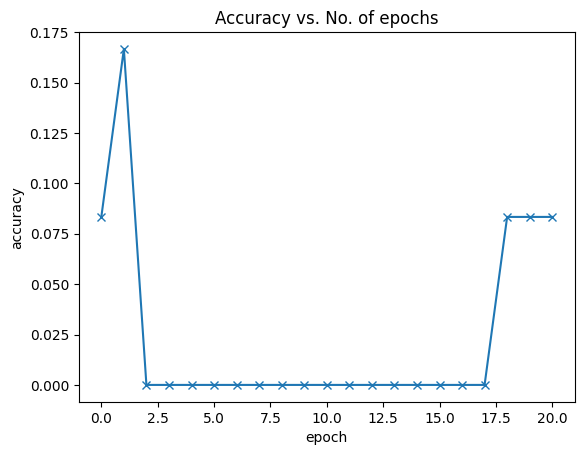

In [37]:
plot_accuracies(history)

In [38]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

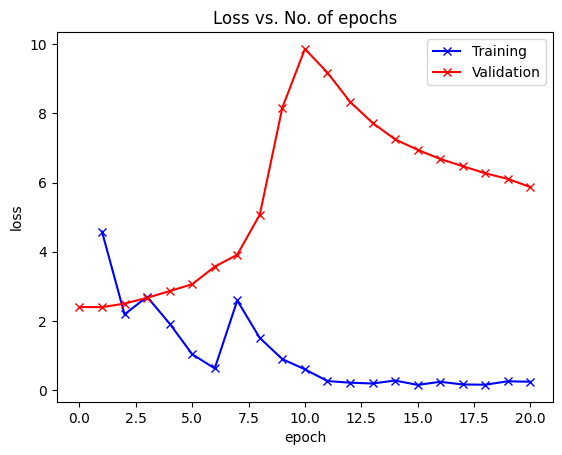

In [39]:
plot_losses(history)

In [40]:
history[-1]

{'val_loss': 5.870005130767822,
 'val_acc': 0.0833333358168602,
 'train_loss': 0.23900409042835236}

# Test with Individual Images

In [41]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [42]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: logo images
Prediction: dropdown Forms


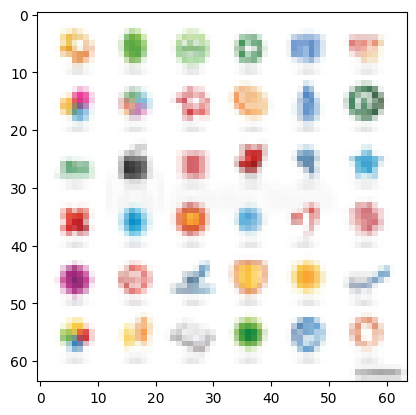

In [43]:
show_image_prediction(*valid_ds[0])

Target: checkbox
Prediction: input fields


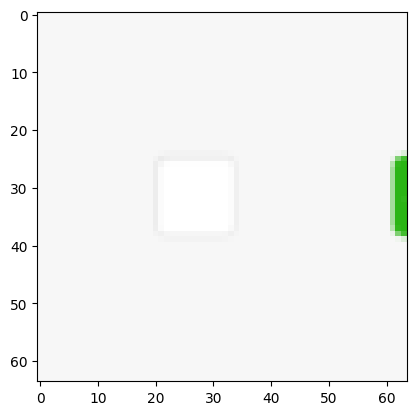

In [44]:
show_image_prediction(*valid_ds[4])

Target: checkbox
Prediction: input fields


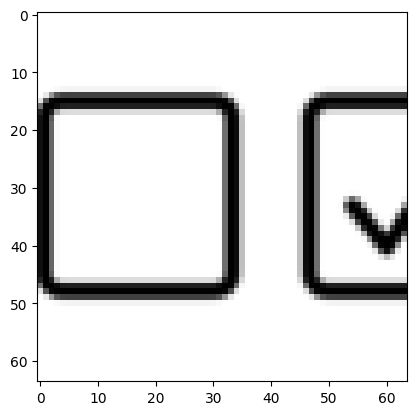

In [45]:
show_image_prediction(*valid_ds[5])

Target: radio
Prediction: modal


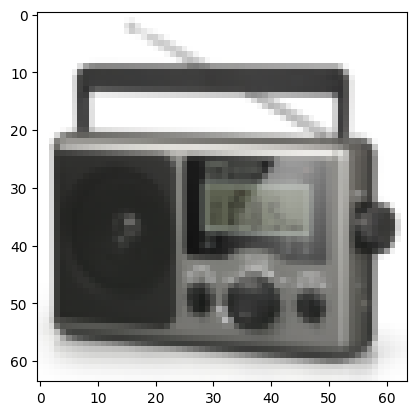

In [46]:
show_image_prediction(*valid_ds[9])

Target: Navigation dots
Prediction: dropdown Forms


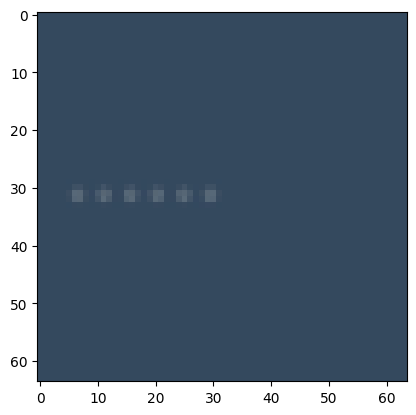

In [47]:
show_image_prediction(*valid_ds[11])